# Example of Dataflow pipeline

This notebooks shows how you can use Dataflow to do distributed data processing.
In this case, the processing involves computing a statistical fit, something that is hard to do in SQL,
but quite straightforward in Python.

## Install Dataflow

In [ ]:
!python3 -m pip install --upgrade apache-beam 'apache-beam[gcp]'

(OR)

Install Apache Beam from source (change the version from 2.12)

In [2]:
%%bash
python3 -m pip install grpcio_tools
git clone https://github.com/apache/beam
cd beam/sdks/python
python3 setup.py sdist
python3 -m pip install './dist/apache-beam-2.12.0.dev0.tar.gz[gcp]'

Processing ./dist/apache-beam-2.12.0.dev0.tar.gz
  Running setup.py bdist_wheel for apache-beam: started
  Running setup.py bdist_wheel for apache-beam: finished with status 'done'
  Stored in directory: /home/jupyter/.cache/pip/wheels/0f/45/e1/848c4f76bb48e71274743acf3991f1f18f6cd229756fc02d82
Successfully built apache-beam


After doing the pip install (above), please restart your kernel.

## Fit rides at a single station to a Gamma distribution

In [3]:
# CHANGE THIS to try this notebook out
PROJECT='cloud-training-demos' 
# London Bicycles is in EU, so process it in EU and make sure bucket is in EU
BUCKET='cloud-training-demos-eu'
REGION='europe-west1'

Let's get the duration of all the rides in a station

In [3]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)
query = """
SELECT duration
FrOM `bigquery-public-data.london_bicycles.cycle_hire`
WHERE start_station_id = 708
"""
df = bq.query(query, location='EU').to_dataframe()
print(df.describe())

            duration
count   19112.000000
mean     1621.541440
std      8781.210736
min         0.000000
25%       360.000000
50%       720.000000
75%      1260.000000
max    687360.000000


Let's plot the distribution of these rides

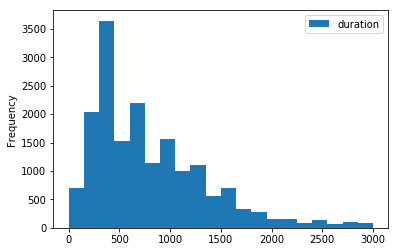

In [4]:
ax = df.plot.hist(range=[0, 3000], bins=20);

Fit to a Gamma distribution

In [5]:
from scipy import stats
ag,bg,cg = stats.gamma.fit(df['duration'])
print(ag, bg, cg)

7.297838862142818e-06 -6.485566100418746e-16 4.234333701782285


## The Beam/Dataflow pipeline to do this at scale

In [7]:
%%writefile requirements.txt
numpy
scipy

Overwriting requirements.txt


In [6]:
import apache_beam as beam
import logging
import datetime, os

def compute_fit(row):
  from scipy import stats
  import numpy as np
  durations = row['duration_array']
  ag, bg, cg = stats.gamma.fit(durations)
  if np.isfinite(ag) and np.isfinite(bg) and np.isfinite(cg):
      result = {}
      result['station_id'] = str(row['start_station_id'])
      result['ag'] = ag
      result['bg'] = bg
      result['cg'] = cg
      yield result

def run_job(in_test_mode=True):
  import shutil, os, subprocess
  job_name = 'computestats' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  
  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './station_stats'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/station_stats'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass
      
  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'sdk_location': 'beam/sdks/python/dist/apache-beam-2.12.0.dev0.tar.gz',
      'requirements_file': 'requirements.txt'
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  
  if in_test_mode:
    query = """
      SELECT start_station_id, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      WHERE start_station_id BETWEEN 700 AND 710
      GROUP BY start_station_id
      """
  else:
     query = """
      SELECT start_station_id, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      GROUP BY start_station_id
      """

  with beam.Pipeline(RUNNER, options = opts) as p:
    (p 
      | 'read_bq' >> beam.io.Read(beam.io.BigQuerySource(query=query, use_standard_sql=True))
      | 'compute_fit' >> beam.FlatMap(compute_fit)
      | 'write_bq' >> beam.io.gcp.bigquery.WriteToBigQuery(
          'ch05eu.station_stats', schema='station_id:string,ag:FLOAT64,bg:FLOAT64,cg:FLOAT64')
    )
    
run_job(in_test_mode = False)
print('Done')

Launching Dataflow job computestats-190312-213401 ... hang on
Done


## Verify output table

In [11]:
%%bigquery stations
SELECT * from ch05eu.station_stats

,station_id,ag,bg,cg
0,578,5.789884e-06,-4.388753e-18,10.488525
1,210,3.293866e-04,-7.224477e-25,1.557510
2,722,6.366779e-06,-4.835904e-21,4.221098
3,690,3.103762e-06,-9.563662e-20,3.827880
4,715,6.983241e-06,-2.297044e-23,4.385585
5,281,4.825999e-06,-2.053353e-14,4.324025
6,517,7.750042e-06,-3.746319e-17,4.671163
7,507,4.223212e-06,-2.751114e-16,5.660142
8,18,2.604135e-06,-9.469348e-17,4.261830
9,773,4.148773e-06,-5.278614e-18,4.688201


In [19]:
stats = stations.describe()
stats

,ag,bg,cg
count,7.990000e+02,7.990000e+02,7.990000e+02
mean,2.874354e+00,-1.937827e+08,5.793930e+05
std,2.468581e+01,5.072298e+09,1.437864e+07
min,6.789745e-07,-1.431073e+11,1.557510e+00
25%,3.499105e-06,-4.121148e-15,4.164106e+00
50%,6.560580e-06,-1.165176e-17,4.282214e+00
75%,1.276729e-05,-9.868189e-20,4.500632e+00
max,3.532822e+02,4.705682e+02,4.045320e+08


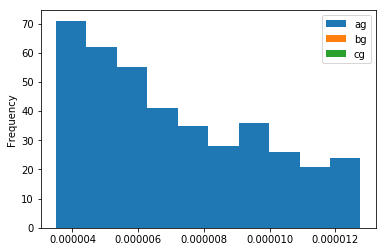

In [30]:
stations.plot.hist('ag', range=[stats['ag']['25%'], stats['ag']['75%']]);

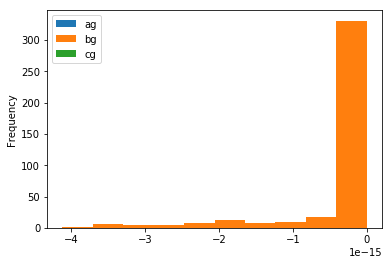

In [27]:
stations.plot.hist('bg', range=[stats['bg']['25%'], stats['bg']['75%']]);

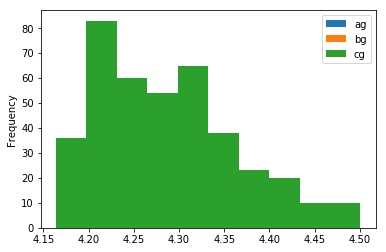

In [26]:
stations.plot.hist('cg', range=[stats['cg']['25%'], stats['cg']['75%']]);

(4.164106368574412, 4.500632386650497)

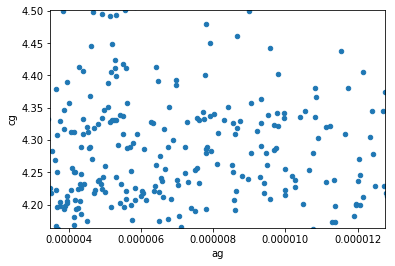

In [33]:
ax = stations.plot.scatter('ag', 'cg');
ax.set_xlim(stats['ag']['25%'], stats['ag']['75%'])
ax.set_ylim(stats['cg']['25%'], stats['cg']['75%'])

Copyright Google Inc. 2019 Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.